In [1]:
from netgen.geom2d import SplineGeometry
from ngsolve import Mesh
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy import dot, exp, sqrt, pi, sin

from labels import EdgeType
from checking_tools import checkLabels, checkNormals
from Trefft_tools import TrefftzSpace, TrefftzFunction,  AssembleRHS, AssembleMatrix
from geometry_tools import Edge

In [39]:
R = 10.
H = 1.
rad = 0.2

from enum import Enum, auto

class ScattererType(Enum):
    PENETRABLE = auto()
    SOUND_SOFT = auto()
    SOUND_HARD = auto()



def createMesh( h_max = 2., R = 10., H=1., c=(0.0), rad = (0.2), scatterer_type = ScattererType.PENETRABLE ):
    '''Creates a netgen mesh and returns the NG-solve wrapper.'''
    geo = SplineGeometry()
    geo.AddRectangle(p1=(-R,-H),
                    p2=( R, H),
                    bcs=["Gamma","Sigma_R","Gamma","Sigma_L"], #consider defining gamma_T and gamma_D
                    leftdomain=1,
                    rightdomain=0)
    match scatterer_type:
        case ScattererType.PENETRABLE:
            geo.AddCircle(c=c,
                        r=rad,
                        bc="D_Omega",
                        leftdomain=2,
                        rightdomain=1)
            geo.SetMaterial (1, "Omega_e")
            geo.SetMaterial (2, "Omega_i")
        case ScattererType.SOUND_SOFT | ScattererType.SOUND_HARD:
            geo.AddCircle(c=c,
                        r=rad,
                        bc="D_Omega",
                        leftdomain=0,
                        rightdomain=1)
            geo.SetMaterial (1, "Omega_e")


    Omega = Mesh(geo.GenerateMesh(maxh= h_max))
    
    return Omega

def testMesh( h_max = 2.):
    '''Creates a simple mesh without scatterer for testing.'''
    geo = SplineGeometry()
    geo.AddRectangle(p1=(-R,-H),
                    p2=( R, H),
                    bcs=["Gamma","Sigma_R","Gamma","Sigma_L"],
                    leftdomain=1,
                    rightdomain=0)
    geo.SetMaterial (1, "Omega_e")

    Omega = Mesh(geo.GenerateMesh(maxh= h_max))
    
    return Omega


def toyMesh():
    '''Creates a toy square mesh without scatterer for testing.'''
    geo = SplineGeometry()
    geo.AddRectangle(p1=(-2*H,-H),
                    p2=( 2*H, H),
                    bcs=["Gamma","Sigma_R","Gamma","Sigma_L"],
                    leftdomain=1,
                    rightdomain=0)
    geo.SetMaterial (1, "Omega_e")

    Omega = Mesh(geo.GenerateMesh(maxh= 2*H))
    
    return Omega

c = (0,-0.0)

Omega = createMesh(R = R, H = H, c=c, rad = rad,  scatterer_type=ScattererType.SOUND_SOFT)
#Omega = testMesh()
# Omega = toyMesh()

In [40]:
Edges = [ Edge(Omega, e)  for e in Omega.edges ]

Checking the orientation of the labels...

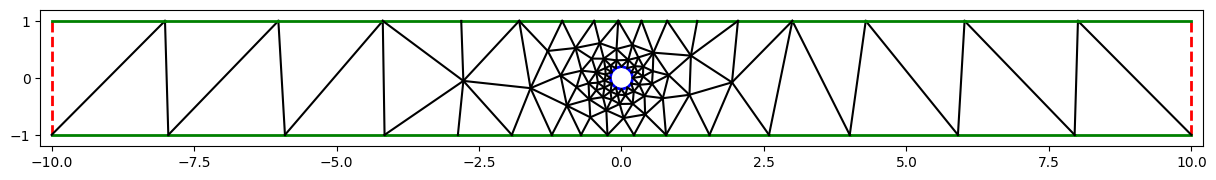

In [41]:
checkLabels(Edges)

and the orientation of the normals...

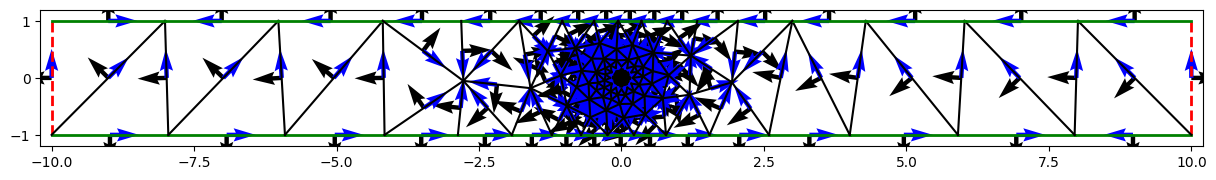

In [42]:
checkNormals(Edges)

and the definition of the "plus" and "minus" quantities...

In [43]:
  # checkPlusMinus(Edges, Baricenters) 

In [44]:
kappa_e = 8.
kappa_i = 5.


In [45]:
# #optimal angle for mode "t" : th = arcsin( lambda /  (2H)) 
# t = 1
# dth = np.arcsin( t*np.pi / (kappa_e*H))
# # optimal number of waves for mode "t":
# Nth = int(2*np.pi / dth)
# Nth 

In [46]:
Nth = 50
th = np.e/10
V = TrefftzSpace(Omega, Nth, {"Omega_i" : kappa_i , "Omega_e" : kappa_e}, th )
# N1 = 45
# N2 = 45
#V = TrefftzSpace(Omega, [N1,N2], {"Omega_i" : kappa_i , "Omega_e" : kappa_e}, th )


In [47]:
A = AssembleMatrix(V, Edges, Np=15, fullsides=True, sparse=True)
NDOF = A.shape[0]
print(f'{NDOF=}')

NDOF=7550


In [48]:
#Ncond = np.linalg.cond(A)
Ncond = -1
Ncond 

-1

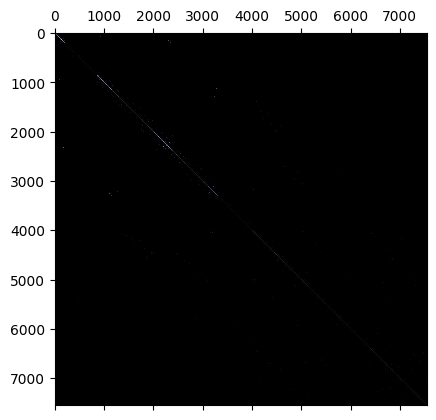

In [49]:
if type(A) is np.ndarray:
    plt.matshow(np.abs(A), cmap='bone')
else:    
    plt.matshow(np.abs(A.toarray()), cmap='bone')
# for y_ in range(0,NDOF,Nth):
#     plt.hlines(y=y_,xmin=0,xmax=NDOF,colors='r')
#     plt.vlines(x=y_,ymin=0,ymax=NDOF,colors='r')


In [55]:
t = 0
B = AssembleRHS(V, Edges, kappa_e, H, d_2=0.5, t=t, full_sides=True)

In [56]:
#DOFs = np.linalg.solve(A,B)
from scipy.sparse.linalg import bicgstab 
from scipy.sparse.linalg import spsolve 
#DOFs, _ = bicgstab(A,B)
A = A.tocsc()
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

In [57]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(-H,H,Ny)
X, Y = np.meshgrid(x,y)

Z =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


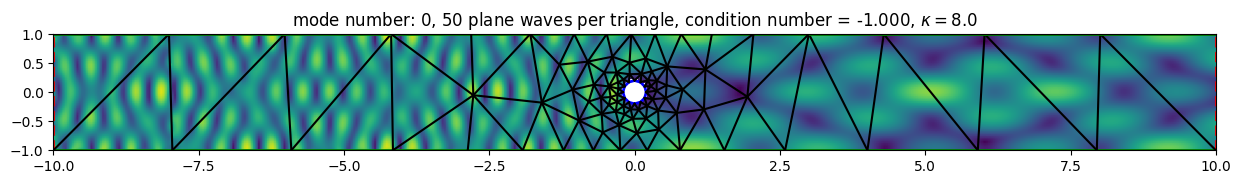

In [58]:
_, ax = plt.subplots( figsize=(15,3))

ax.imshow(np.abs(Z), origin="lower", extent=[-R,R,-H,H])
#v = 1
#ax.imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H], vmin=-v, vmax=v)

checkLabels(Edges, ax)
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([-H,H])
plt.title(f'mode number: {t}, {Nth} plane waves per triangle, condition number = {Ncond: .3f}, $\\kappa={kappa_e:.1f}$')

save = False
if save:
    plt.savefig(f'test_{t}_{Nth}_d2.png')

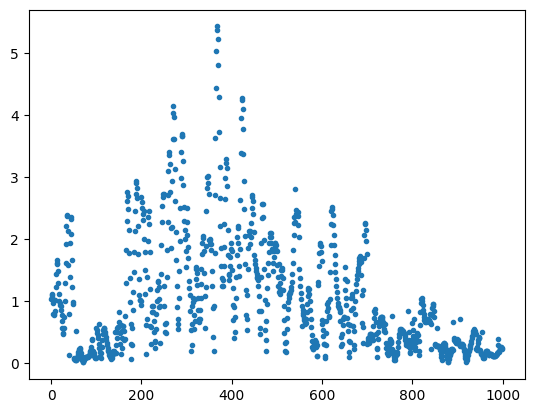

In [38]:
plt.plot(np.abs(DOFs),'.')

In [27]:
# from exact_solutions import exact_sound_soft
# Z_exact = exact_sound_soft(X,Y,kappa_e, H, rad=rad, c=c, theta_inc=0, M = 40, N = 15)

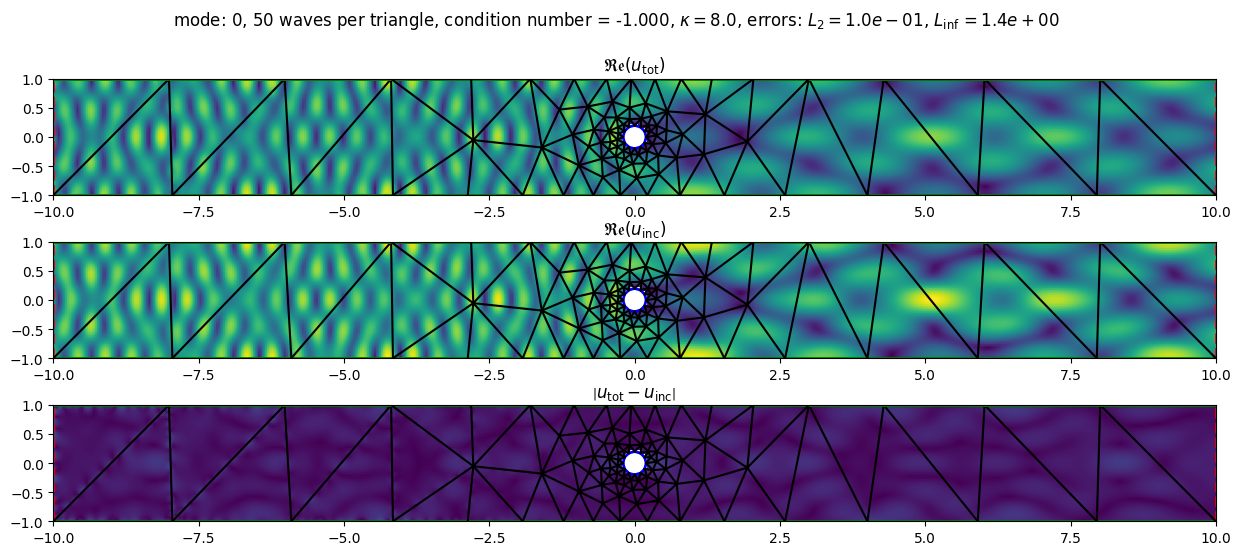

In [59]:
fig, ax = plt.subplots( nrows = 3, figsize=(15,6))

ax[0].imshow(np.abs(Z), origin="lower", extent=[-R,R,-H,H])

checkLabels(Edges, ax[0])
ax[0].axis('square')
ax[0].set_xlim([-R,R])
ax[0].set_ylim([-H,H])

Z_inc = np.exp(1j*np.sqrt(complex(kappa_e**2 - (t*np.pi/H)**2))*X)*np.cos(t*np.pi*Y/H)

diff = np.where( (X-c[0])**2 + (Y-c[1])**2> rad**2, np.abs(Z - Z_exact), 0.)

L2_err = np.sqrt(np.mean(diff**2))
L_inf_err = np.max(diff)


ax[1].imshow(np.abs(Z_exact), origin="lower", extent=[-R,R,-H,H])

checkLabels(Edges, ax[1])
ax[1].axis('square')
ax[1].set_xlim([-R,R])
ax[1].set_ylim([-H,H])



ax[2].imshow(np.abs(Z-Z_exact), origin="lower", extent=[-R,R,-H,H])

checkLabels(Edges, ax[2])
ax[2].axis('square')
ax[2].set_xlim([-R,R])
ax[2].set_ylim([-H,H])

fig.suptitle(f'mode: {t}, {Nth} waves per triangle, condition number = {Ncond: .3f}, $\\kappa={kappa_e:.1f}$, errors: $L_2={L2_err:.1e}$, $L_\\inf={L_inf_err:.1e}$')
ax[0].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
ax[1].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{inc}\\right)$')
ax[2].set_title('$\\left\\vert u_\\mathrm{tot}-u_\\mathrm{inc}\\right\\vert$')

save = False
if save:
    plt.savefig(f'mode_{t}_{Nth}_no_d2_no_wave_in_basis.png')

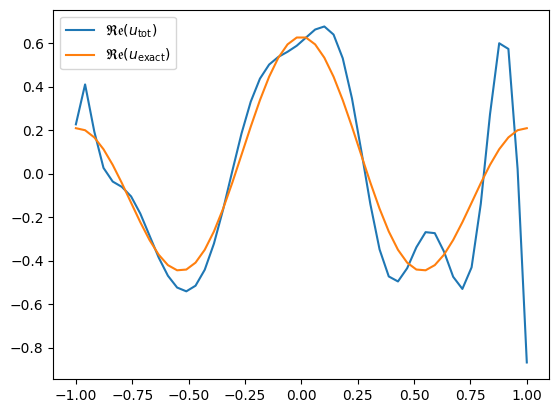

In [60]:
plt.plot(y,np.real(Z[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
plt.plot(y,np.real(Z_exact[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{exact}\\right)$')

plt.legend()
